In [1]:
import makemore
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [2]:
CHARS = makemore.CHARS
CHARS

'.abcdefghijklmnopqrstuvwxyz'

# counting bigrams

a **bigram** is a sequence of 2 characters. for example, "th", or "qx". we

here we load a file that contains a collection of words containing only lowercase English letters a-z, with one word per line. we conver this to a Python list of strings, and then count up all adjacent pairs of characters in all the words.

we also insert a special character "." that stands for "start of word" or "end of word" at the beginning and end of each word, and count up the adjacent pairs. for each possible adjacent pair $(c, d) \in \{a, \ldots, z, .\}^2$, we maintain a count $n_{cd}$, the number of times that pair has been encountered in the training set.

there are two possible data sets: one of names, and one of words from Ubuntu's `/usr/share/dict/american-english` (with all the words with non-lowercase characters removed).

In [3]:
words = makemore.load_words_from_file('names.txt')
counts = makemore.bigram_model(words)

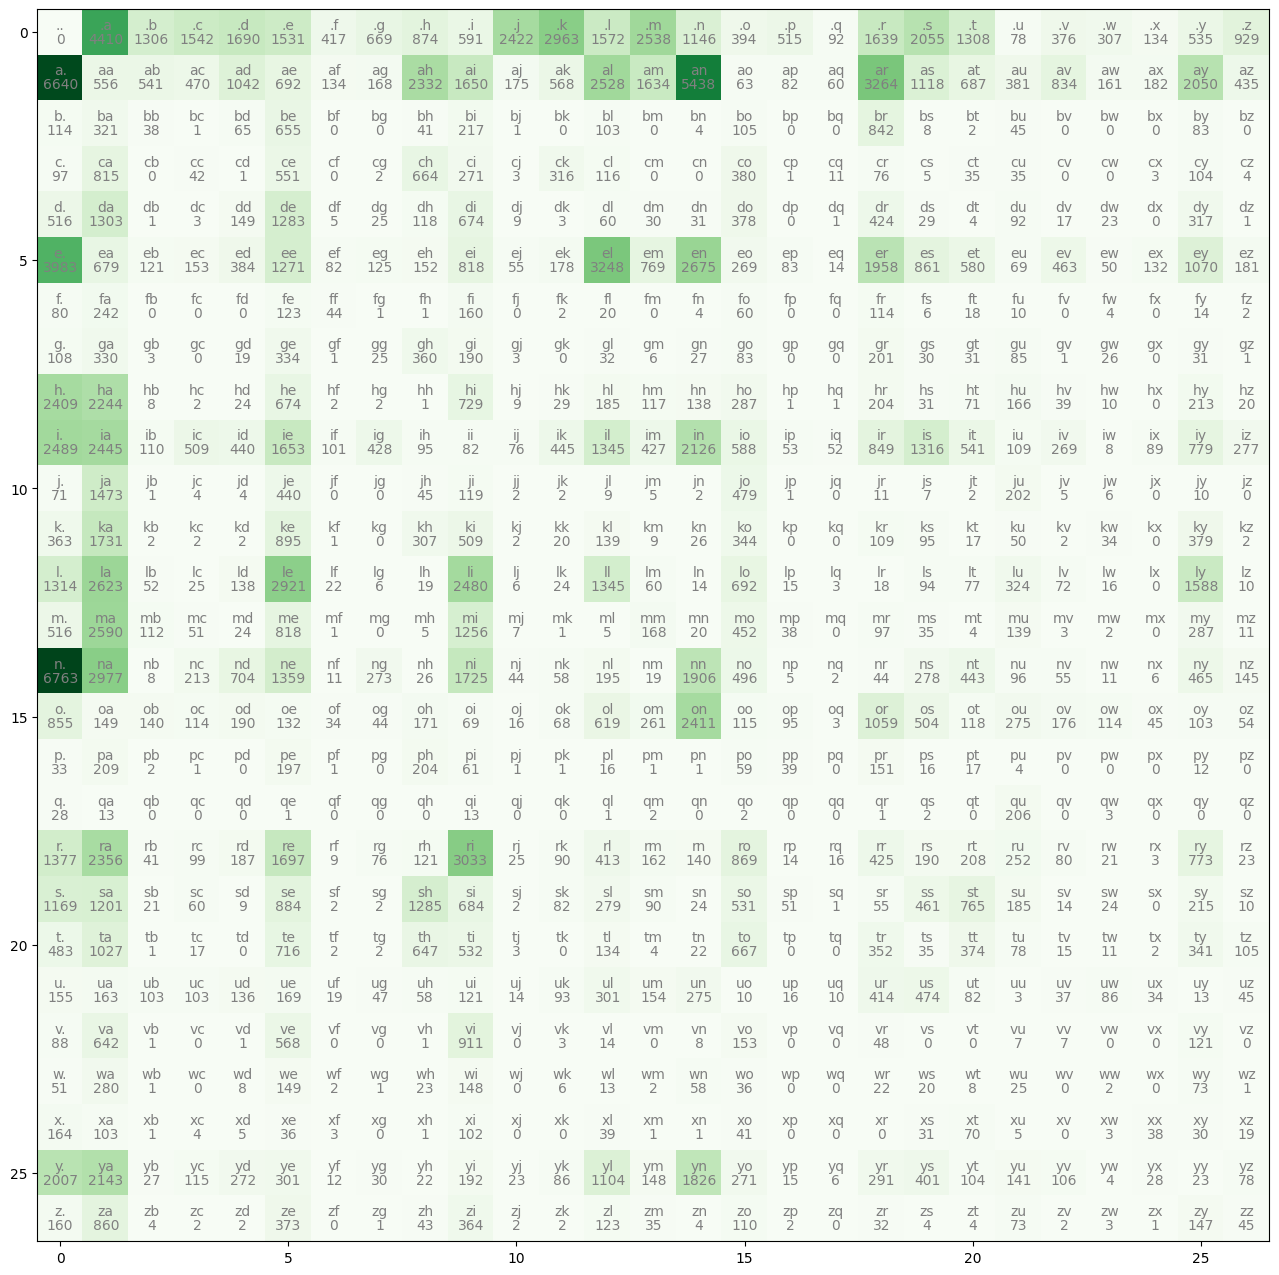

In [4]:
makemore.plot_bigram_frequencies(counts)

In [ ]:
words = makemore.load_words_from_file('american-english.txt')
counts = makemore.bigram_model(words)

In [ ]:
makemore.plot_bigram_frequencies(counts)

# sample

In [5]:
# added count of 1 for smoothing out unobserved bigrams
count_dists = makemore.make_count_dists(counts)

In [8]:
seed = 2**31 - 1
print(f" --- sampling using seed {seed} --- ")
g = torch.Generator().manual_seed(seed)

def get_sample(P, g):
  samples = torch.multinomial(P, num_samples=1, replacement=True, generator=g)
  return samples[0].item()

 --- sampling using seed 2147483647 --- 


In [9]:
#P = count_dists[0]
#curr_idx = get_sample(P)
curr_idx = 0
output = ''

for i in range(200):
  P = count_dists[curr_idx]
  curr_idx = get_sample(P, g)
  output += ' ' if curr_idx == 0 else CHARS[curr_idx]
  
for word in output.split():
  print(f"{word}.")

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.
h.
br.
a.
jayn.
ilemannariaenien.
be.
f.
akiinela.
trttanakeroruceyaaxatona.
lamoynayrkiedengin.
torrederahnn.
ellovyllobrqura.
ay.
h.


In [ ]:
test_words = ["szygy"]
anll = makemore.calculate_anll_loss(test_words, count_dists)
print(anll)

# neural network + gradient descent approach

We train a linear 27-unit softmax layer on a dataset consisting of a collection of words (though it might as well be a sequence of characters from the perspective of the training algorithm).

Each of the 27 possible characters (a-z and ".") is identified with a (unique) number from 1-27. ('.' => 0, 'a' => 1, 'b' => 2, etc.). The input to the network is a 27-dimensional one-hot encoded vector of an input character number. The result is a probability distribution over possible next characters.

Therefore, each input vector $\textbf{x} = (x_1, \ldots, x_{27})$ is a one-hot vector. Each training label, $y$, is not a vector, on the other hand, but an integer $y \in \{1, \ldots, 27\}$.

$X \in \mathbb{R}^{m \times 27}$, where $m$ is the number of training samples, is defined by

$$X := [x^{(1)}, \ldots, x^{(m)}]^T \in \mathbb{R}^{m \times 27}$$

The output labels are:

$$Y = [y^{(1)}, \ldots, y^{(m)}]^T \in \{1, \ldots, 27\}^{m}$$

in the matrix $W \in \mathbb{R}^{27 \times 27}$, each column $W[:,i]$ is the weight vector associated with unit $i$ in the linear layer. For $\textbf{x} \in \mathbb{R}^{1 \times 27}$, $\textbf{x} W$ is the row vector of activations for the units in the linear layer. Similarly, $X W$ is the matrix of linear unit activations for each input $X[i,:]$ in $X$.

We wish to turn each output vector $\textbf{x} W$ into a probability distribution over the 27 possible characters. This is achieved by applying the softmax function:

$$\text{softmax}(X W)$$

where for $\textbf{z} \in \mathbb{R}^d$,

$$\text{softmax}(\textbf{z}) = \frac{\exp(\textbf{z})}{\sum_k e^{z_k}} = \frac{1}{\sum_k e^{z_k}}(e^{z_i} : i = 1, \ldots, d)$$

$\text{softmax}(\textbf{z})$ is a probability distribution over $\{ 1, \ldots, d \}$

## defining a loss function

for maximum-likelihood estimation, we have:

$$\theta_{ML} := \text{argmax}_{\theta} p_{model}(Y | X ; \theta)$$
$$= \text{argmax}_{\theta} \sum_{i=1}^m \log p_{model}(y^{(i)} | x^{(i)} ; \theta)$$
$$= \text{argmin}_{\theta} -\sum_{i=1}^m \log p_{model}(y^{(i)} | x^{(i)} ; \theta)$$

So we will seek to minimize the negative log likelihood of the observed data, and define the loss function

$$L(\theta) := - \sum_{i=1}^m \log p_{model}(y^{(i)} | x^{(i)} ; \theta)$$

For our neural network, we have:

$$\log p_{model}(y^{(i)} | x^{(i)} ; \theta) = \log \text{softmax}(x^{(i)T} W)_{y^{(i)}}$$

if $x^{(i)}$ is a one-hot vector corresponding to $j \in \{1, \ldots, 27\}$, and $y^{(i)} = k \in \{1, \ldots, 27\}$, then:

$$\log p_{model}(y^{(i)} | x^{(i)} ; \theta) = \log \text{softmax}(W[j,:])_{k}$$
$$= \log \left( \frac{\exp(W_{jk})}{\sum_l e^{W_{jl}}} \right)$$

In [10]:
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [11]:
xs = []
ys = []

for word in words:
  word = f".{word}."
  for i in range(len(word) - 1):
    idx_a = makemore.CHAR_INDICES[word[i]]
    idx_b = makemore.CHAR_INDICES[word[i+1]]
    xs.append(idx_a)
    ys.append(idx_b)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs, ys)

tensor([ 0,  5, 13,  ..., 25, 26, 24]) tensor([ 5, 13, 13,  ..., 26, 24,  0])


In [12]:
learning_rate = 50
num_iters = 200
reg_param = 0.01

for i in range(num_iters):
  oh = F.one_hot(xs, num_classes=27).float()
  logits = oh @ W
  sm_counts = logits.exp()
  probs = sm_counts / sm_counts.sum(1, keepdims=True)
  
  # with weight decay
  loss = -probs[torch.arange(ys.shape[0]), ys].log().mean() + reg_param * (W**2).mean()
  print(loss.item())
  
  W.grad = None
  loss.backward()
  
  W.data += -learning_rate * W.grad

3.656919479370117
3.3099260330200195
3.1152124404907227
2.989792823791504
2.899862289428711
2.8344156742095947
2.7857143878936768
2.748554229736328
2.71941876411438
2.6959192752838135
2.676476240158081
2.6600470542907715
2.6459314823150635
2.633643388748169
2.622833490371704
2.613243818283081
2.6046788692474365
2.59698486328125
2.5900397300720215
2.583742380142212
2.578010320663452
2.572772979736328
2.567971706390381
2.5635554790496826
2.5594801902770996
2.5557093620300293
2.5522103309631348
2.5489556789398193
2.5459210872650146
2.543085813522339
2.5404322147369385
2.5379440784454346
2.5356078147888184
2.5334115028381348
2.531343460083008
2.5293946266174316
2.5275564193725586
2.525819778442383
2.524178981781006
2.5226266384124756
2.5211565494537354
2.519763469696045
2.518442153930664
2.5171875953674316
2.515995979309082
2.5148630142211914
2.513784408569336
2.512756824493408
2.511777400970459
2.5108425617218018
2.509950876235962
2.5090980529785156
2.50828218460083
2.5075016021728516
2.5

# sample from NN

In [13]:
g = torch.Generator().manual_seed(seed)
curr_idx = 0
output = ''

for i in range(200):
  oh = F.one_hot(torch.tensor([curr_idx]), num_classes=27).float()
  logits = oh @ W
  sm_counts = logits.exp()
  probs = sm_counts / sm_counts.sum(1, keepdims=True)
  
  curr_idx = get_sample(probs, g)
  output += ' ' if curr_idx == 0 else CHARS[curr_idx]
  
for word in output.split():
  print(f"{word}.")

mor.
axx.
minaymoryles.
kondmaisah.
anchthizarie.
odaren.
iaddash.
h.
jionatien.
egwulo.
h.
br.
a.
jayn.
ilemannariaenien.
be.
f.
akiinela.
trttanakeroruceyaaxatona.
lamoyonutonadengin.
torrederahnn.
ellovyllpasskh.
a.
wai.
